In [1]:
from dotenv import load_dotenv
import os
from pymongo import MongoClient

# Load variables from .env file
load_dotenv()

# Get MongoDB connection string from environment
CONNECTION_STRING = os.getenv("MongoURI")
client=""
def  get_database():
    try:
        # Initialize MongoClient with connection string
        client = MongoClient(CONNECTION_STRING)
        
        # Test connection by accessing server info
        client.server_info()  # This will raise an error if connection fails
        
        print("Connected successfully to the database!")
        return client['user_shopping_list']
    
    except Exception as e:
        print(f"Failed to connect to the database: {str(e)}")
        return None

if __name__ == "__main__":
    dbname = get_database()
    if dbname is not None:
        print("Database connection is ready to use.")
    else:
        print("Database connection failed.")

Connected successfully to the database!
Database connection is ready to use.


In [2]:
# Ensure the client is initialized properly
if client == "":
    client = MongoClient(CONNECTION_STRING)

# List collections
db = client['revostate']
collections = db.list_collection_names()
print("Collections in the database:")
for collection in collections:
    print(f"- {collection}")

Collections in the database:
- account
- verification
- appointments
- properties
- purchases
- companies
- packages
- systemadmins
- users
- session


In [3]:
from dotenv import load_dotenv
import os
from pymongo import MongoClient
from pymongo.operations import SearchIndexModel
from sentence_transformers import SentenceTransformer

# Load variables from .env file
load_dotenv()
CONNECTION_STRING = os.getenv("MongoURI")

# def document_to_text(doc, is_company=False):
#     """Convert specified document fields to a text string for embedding."""
#     parts = []
    
#     if is_company:
#         if 'realEstateName' in doc and doc['realEstateName']:
#             parts.append(doc['realEstateName'])
#         if 'description' in doc and doc['description']:
#             parts.append(doc['description'])
#         if 'address' in doc:
#             if isinstance(doc['address'], dict):
#                 for field in ['region', 'city', 'specificLocation']:
#                     value = doc['address'].get(field)
#                     if value:
#                         parts.append(value)
#             elif isinstance(doc['address'], str):
#                 parts.append(doc['address'])
#     else:
#         if 'title' in doc and doc['title']:
#             parts.append(doc['title'])
#         if 'description' in doc and doc['description']:
#             parts.append(doc['description'])
#         if 'price' in doc and doc['price'] is not None:
#             parts.append(f"price: {doc['price']}")
#         if 'area' in doc and doc['area'] is not None:
#             parts.append(f"area: {doc['area']}")
#         if 'landArea' in doc and doc['landArea'] is not None:
#             parts.append(f"landArea: {doc['landArea']}")
#         if 'listingType' in doc and doc['listingType']:
#             parts.append(doc['listingType'])
#         if 'amenities' in doc and doc['amenities']:
#             parts.append(f"amenities: {', '.join(str(x) for x in doc['amenities'])}")
#         if 'address' in doc:
#             if isinstance(doc['address'], dict):
#                 for field in ['region', 'city', 'specificLocation']:
#                     value = doc['address'].get(field)
#                     if value:
#                         parts.append(value)
#             elif isinstance(doc['address'], str):
#                 parts.append(doc['address'])
    
#     text = ' '.join(parts)
#     return f"search_document: {text}"

# def add_embeddings(collection, model, is_company=False):
#     """Add embeddings to documents using sentence-transformers/all-MiniLM-L6-v2 (384 dimensions)."""
#     for doc in collection.find():
#         if "revoemb" in doc:
#             continue
#         text = document_to_text(doc, is_company)
#         if not text.strip():
#             continue
#         embedding = model.encode([text])[0].tolist()
#         collection.update_one(
#             {"_id": doc["_id"]},
#             {"$set": {"revoemb": embedding}}
#         )
#     print(f"Embeddings added to {collection.name} collection.")

# def create_search_indexes(client):
#     """Create vector search indexes for properties and companies."""
#     try:
#         client.server_info()
#         print("Connected successfully to the database!")
        
#         db = client['revostate']
#         properties_collection = db['properties']
#         companies_collection = db['companies']
        
#         # Remove existing revoemb fields
#         properties_collection.update_many({}, {"$unset": {"revoemb": ""}})
#         companies_collection.update_many({}, {"$unset": {"revoemb": ""}})
#         print("Removed existing revoemb fields from properties and companies collections.")
        
#         model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
        
#         add_embeddings(properties_collection, model, is_company=False)
#         add_embeddings(companies_collection, model, is_company=True)
        
#         properties_vector_index = SearchIndexModel(
#             definition={
#                 "fields": [
#                     {
#                         "type": "vector",
#                         "numDimensions": 384,  # Updated to match all-MiniLM-L6-v2
#                         "path": "revoemb",
#                         "similarity": "cosine"
#                     }
#                 ]
#             },
#             name="properties_vector_index",
#             type="vectorSearch"
#         )
#         properties_collection.create_search_index(properties_vector_index)
#         print("Vector search index created for 'properties' collection.")
        
#         # Create Vector Search Index for Companies
#         companies_vector_index = SearchIndexModel(
#             definition={
#                 "fields": [
#                     {
#                         "type": "vector",
#                         "numDimensions": 384,  # Updated to match all-MiniLM-L6-v2
#                         "path": "revoemb",
#                         "similarity": "cosine"
#                     }
#                 ]
#             },
#             name="companies_vector_index",
#             type="vectorSearch"
#         )
#         companies_collection.create_search_index(companies_vector_index)
#         print("Vector search index created for 'companies' collection.")
        
#         print("\nSearch Indexes for 'properties':")
#         for index in properties_collection.list_search_indexes():
#             print(index)
#         print("\nSearch Indexes for 'companies':")
#         for index in companies_collection.list_search_indexes():
#             print(index)
        
#         return db
    
#     except Exception as e:
#         print(f"Failed to create indexes: {str(e)}")
#         return None

class MongoResult:
    def __init__(self, query, collection, is_company=False):
        self.query = query
        self.collection = collection
        self.is_company = is_company
        self.model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
        self.vectorized_query = self.vectorize_query(query)
    
    def vectorize_query(self, query):
        """Vectorize the query with search_query prefix (384 dimensions)."""
        query_text = f"search_query: {query}"
        embedding = self.model.encode([query_text])[0].tolist()
        return embedding
    
    def search(self, limit=10):
        """Perform vector search using the revoemb field."""
        try:
            pipeline = [
                {
                    "$vectorSearch": {
                        "index": "companies_vector_index" if self.is_company else "properties_vector_index",
                        "path": "revoemb",
                        "queryVector": self.vectorized_query,
                        "numCandidates": 100,
                        "limit": limit
                    }
                },
                {
                    "$project": {
                        "_id": 1,
                        "title": 1 if not self.is_company else None,
                        "description": 1,
                        "realEstateName": 1 if self.is_company else None,
                        "address": 1,
                        "price": 1 if not self.is_company else None,
                        "area": 1 if not self.is_company else None,
                        "landArea": 1 if not self.is_company else None,
                        "listingType": 1 if not self.is_company else None,
                        "amenities": 1 if not self.is_company else None,
                        "score": {"$meta": "vectorSearchScore"}
                    }
                }
            ]
            
            results = self.collection.aggregate(pipeline)
            return list(results)
        
        except Exception as e:
            print(f"Search failed: {str(e)}")
            return []

def main():
    # Initialize MongoClient
    client = MongoClient(CONNECTION_STRING)
    db=client['revostate']
    
    try:
        # Create indexes and get database
        # db = create_search_indexes(client)
        # if db is None:
        #     return
        
        # Example search for companies
        companies_collection = db['companies']
        query = "real estates in los_angeles"
        searcher = MongoResult(query, companies_collection, is_company=True)
        results = searcher.search(limit=10)
        
        print("\nVector Search Results for Companies:")
        print("companiesresults", results)
        # for doc in results:
        #     print(f"Name: {doc.get('realEstateName')}, Address: {doc.get('address', {}).get('city')}, "
        #           f"Score: {doc.get('score', 0):.4f}")
        
        # Example search for properties
        properties_collection = db['properties']
        query = "luxury villa in Bole for sale"
        searcher = MongoResult(query, properties_collection, is_company=False)
        results = searcher.search(limit=10)
        
        print("\nVector Search Results for Properties:")
        print("propertiesresults", results)
        for doc in results:
            print(f"Title: {doc.get('title')}, Address: {doc.get('address', {}).get('city')}, "
                  f"Price: {doc.get('price', 0)}, Listing: {doc.get('listingType')}, "
                  f"Score: {doc.get('score', 0):.4f}")
    
    except Exception as e:
        print(f"Error: {str(e)}")
    
    # finally:
    #     client.close()

if __name__ == "__main__":
    main()

/home/jibril/Documents/Revoestatechatbot/revochatbot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Vector Search Results for Companies:
companiesresults [{'_id': ObjectId('6806e914fb1d0b4b9c695358'), 'realEstateName': 'Gift Real Estates', 'description': 'GIFT Real Estate P.L.C. is one of the core businesses of the GIFT Business Group. and it  is one of the pioneering real estate companies in Ethiopia. It was established in 2005. It has established a solid reputation as a result of its substantial contributions throughout the years to the growth of Ethiopia’s real estate market. Its ambitious goal is to provide services to several cities in Ethiopia and other African nations.', 'address': '{"region":"california","city":"los_angeles","specificLocation":"Blue moon bldg, Cameroon St, Addis Ababa","geoPoint":{"type":"Point","coordinates":[36.8372893,7.6753269]}}', 'title': None, 'price': None, 'area': None, 'landArea': None, 'listingType': None, 'amenities': None, 'score': 0.7541102170944214}, {'_id': ObjectId('6807d338a67df4f92c3086c9'), 'address': 'Addis Ababa, Ethiopia', 'description

In [4]:


from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool




In [5]:
from langchain_mongodb.vectorstores import MongoDBAtlasVectorSearch
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
from langchain.embeddings.base import Embeddings
from langchain_core.documents import Document
import os
from langchain_huggingface import HuggingFaceEmbeddings

embedmodel = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Custom embedding class
# class SentenceTransformerEmbeddings(Embeddings):
#     def __init__(self, model_name: str):
#         self.model = SentenceTransformer(model_name)
    
#     def embed_documents(self, texts: list[str]) -> list[list[float]]:
#         return self.model.encode(texts, convert_to_tensor=False).tolist()
    
#     def embed_query(self, text: str) -> list[float]:
#         query_text = f"search_query: {text}"
#         embedding = self.model.encode(query_text, convert_to_tensor=False).tolist()
#         print("embedded query", embedding)
#         return embedding

# Load environment variables
load_dotenv()
CONNECTION_STRING = os.getenv("MongoURI")
if not CONNECTION_STRING:
    raise ValueError("MongoURI not found in environment variables.")

# Initialize the embedding model
# embedmodel = SentenceTransformerEmbeddings("all-MiniLM-L6-v2")

# Instantiate the vector store for properties
properties_vector_store = MongoDBAtlasVectorSearch.from_connection_string(
    connection_string=CONNECTION_STRING,
    namespace="revostate.properties",
    embedding=embedmodel,
    index_name="properties_vector_index",
    embedding_key="revoemb",
    # text_key="description",
    relevance_score_fn="cosine"
)

# Create a retriever for properties
properties_retriever = properties_vector_store.as_retriever(
    search_kwargs={
        "k": 10,
        "score_threshold": 0.7,
    }
)

# Instantiate the vector store for companies
companies_vector_store = MongoDBAtlasVectorSearch.from_connection_string(
    connection_string=CONNECTION_STRING,
    namespace="revostate.companies",
    embedding=embedmodel,
    index_name="companies_vector_index",
    embedding_key="revoemb",
    # text_key="description",
    relevance_score_fn="cosine"
)

# Create a retriever for companies
companies_retriever = companies_vector_store.as_retriever(
    search_kwargs={
        "k": 10,
        "score_threshold": 0.7,
    }
)

# Test the properties retriever
try:
    results = properties_retriever.invoke("luxury villa in Bole for sale")
    print("Properties search results:",results)

    for result in results:
        score = result.metadata.get("score", 0)
        print(f"Score: {score:.4f}")
        print(f"Full Document: {result.metadata}")
        print("---")
except Exception as e:
    print(f"Error: {e}")

# Test the companies retriever
try:
    results = companies_retriever.invoke("real estates in Addis Ababa")
    print("Companies search results:")
    for result in results:
        score = result.metadata.get("score", 0)
        print(f"Score: {score:.4f}")
        print(f"Full Document: {result.metadata}")
        print("---")
except Exception as e:
    print(f"Error: {e}")

Properties search results: []
Companies search results:


In [6]:
# Direct vector search test
results = properties_vector_store.similarity_search("villa in Bole", k=3)
print("\nDirect search results:")
for doc in results:
    print(f"Content: {doc.page_content}\nMetadata: {doc.metadata}\n")


Direct search results:


In [7]:
from langchain_mongodb.vectorstores import MongoDBAtlasVectorSearch
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
from pymongo import MongoClient
import os
import traceback

# Load environment variables
load_dotenv()
CONNECTION_STRING = os.getenv("MongoURI")
if not CONNECTION_STRING:
    raise ValueError("MongoURI not found in environment variables.")

# Initialize MongoDB client and collections
mongo_client = MongoClient(CONNECTION_STRING)
properties_collection = mongo_client["revostate"]["properties"]
companies_collection = mongo_client["revostate"]["companies"]

# Verify data in collections
print("Properties count:", properties_collection.count_documents({}))
print("Companies count:", companies_collection.count_documents({}))

# Initialize the embedding model
embedmodel = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Instantiate the vector store for properties
properties_vector_store = MongoDBAtlasVectorSearch(
    collection=properties_collection,
    embedding=embedmodel,
    index_name="properties_vector_index",
    embedding_key="revoemb",
    text_key="description",
    relevance_score_fn="cosine"
)

# Create a retriever for properties
properties_retriever = properties_vector_store.as_retriever(
    search_kwargs={
        "k": 10,
        "score_threshold": 0.1  # Lowered to increase result likelihood
    }
)

# Instantiate the vector store for companies
companies_vector_store = MongoDBAtlasVectorSearch(
    collection=companies_collection,
    embedding=embedmodel,
    index_name="companies_vector_index",
    embedding_key="revoemb",
    text_key="description",
    relevance_score_fn="cosine"
)

# Create a retriever for companies
companies_retriever = companies_vector_store.as_retriever(
    search_kwargs={
        "k": 10,
        "score_threshold": 0.1
    }
)

# Test the properties retriever
try:
    results = properties_retriever.invoke("luxury villa in Bole for sale")
    print("Properties search results:", results)
    for result in results:
        score = result.metadata.get("score", 0)
        print(f"Score: {score:.4f}")
        print(f"Full Document: {result.metadata}")
        print("---")
except Exception as e:
    print(f"Properties Error: {str(e)}")
    print("Stack Trace:")
    traceback.print_exc()

# Test the companies retriever
try:
    results = companies_retriever.invoke("real estates in Addis Ababa")
    print("Companies search results:")
    for result in results:
        score = result.metadata.get("score", 0)
        print(f"Score: {score:.4f}")
        print(f"Full Document: {result.metadata}")
        print("---")
except Exception as e:
    print(f"Companies Error: {str(e)}")


Properties count: 32
Companies count: 6
Properties search results: [Document(id='681392679f2eaca947a9610d', metadata={'_id': '681392679f2eaca947a9610d', 'title': '5 Bedroom Villa', 'price': 31861740, 'area': 445, 'address': {'region': 'Addis Ababa', 'city': 'Bole', 'specificLocation': 'Bole,Wello sefer', 'geoPoint': {'type': 'Point', 'coordinates': [36.8372893, 7.6753269]}}, 'propertyType': 'Villa', 'status': 'available', 'images': ['https://res.cloudinary.com/dnf1foxjf/image/upload/v1746113123/revostate-images/revostate-images/image-1746113111647-real-estate-photography-interior-photo-750x500.jpg', 'https://res.cloudinary.com/dnf1foxjf/image/upload/v1746113123/revostate-images/revostate-images/image-1746113111657-premium_photo-1670360414483-64e6d9ba9038.jpg', 'https://res.cloudinary.com/dnf1foxjf/image/upload/v1746113120/revostate-images/revostate-images/image-1746113111659-istockphoto-1321598038-612x612.jpg'], 'bedrooms': 5, 'bathrooms': 3, 'builtInYear': 2023, 'isFeatured': True, 'i

In [8]:
from langchain_core.tools import tool
from langchain_core.documents import Document
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langchain_core.messages import  AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
from pymongo import MongoClient
from typing import  List, Optional
import logging
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load environment variables
load_dotenv()
CONNECTION_STRING = os.getenv("MongoURI")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if not GROQ_API_KEY:
    raise ValueError("GROQ_API_KEY not found in environment variables.")

# Initialize MongoDB client and collections
if not CONNECTION_STRING:
    raise ValueError("MongoURI not found in environment variables.")
# Initialize MongoDB client and collections
mongo_client = MongoClient(CONNECTION_STRING)
properties_collection = mongo_client["revostate"]["properties"]
companies_collection = mongo_client["revostate"]["companies"]

# Verify data in collections
logger.info("Properties count: %d", properties_collection.count_documents({}))
logger.info("Companies count: %d", companies_collection.count_documents({}))
embedmodel = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

def raw_vector_search(collection, query: str, index_name: str, k: int = 10, filters: dict = None):
    try:
        query_embedding = embedmodel.embed_query(query)  # Directly embed the raw query
        pipeline = [
            {
                "$vectorSearch": {
                    "index": index_name,
                    "path": "revoemb",
                    "queryVector": query_embedding,
                    "numCandidates": k * 10,
                    "limit": k
                }
            }
        ]
        if filters:
            pipeline.insert(0, {"$match": filters})
        pipeline.append({
            "$project": {
                "revoemb": 0,  # Exclude large embedding field
                "score": {"$meta": "vectorSearchScore"}
            }
        })
        results = list(collection.aggregate(pipeline))
        return [Document(
            page_content=r.get("description", ""),
            metadata={k: v for k, v in r.items() if k != "description"},
            score=r.get("score", 0)
        ) for r in results]
    except Exception as e:
        logger.error("Vector search error: %s", str(e))
        return []

# Define LangChain tools
@tool
def properties_vector_search(query: str, filters: dict = None) -> list[dict]:
    """Search for properties based on a query and optional MongoDB filters."""
    try:
        results = raw_vector_search(properties_collection, query, "properties_vector_index", k=10, filters=filters)
        logger.info("Properties query: %s, filters: %s, results: %d", query, filters, len(results))
        return [{"content": r.page_content, "metadata": r.metadata, "score": r.metadata.get("score", 0)} for r in results]
    except Exception as e:
        logger.error("Properties vector search error: %s", str(e))
        return []

@tool
def companies_vector_search(query: str, filters: dict = None) -> list[dict]:
    """Search for real estate companies based on a query and optional MongoDB filters."""
    try:
        results = raw_vector_search(companies_collection, query, "companies_vector_index", k=10, filters=filters)
        logger.info("Companies query: %s, filters: %s, results: %d", query, filters, len(results))
        return [{"content": r.page_content, "metadata": r.metadata, "score": r.metadata.get("score", 0)} for r in results]
    except Exception as e:
        logger.error("Companies vector search error: %s", str(e))
        return []
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatGroq(model_name="llama3-70b-8192", api_key=GROQ_API_KEY)

abot = Agent(model, [tool], system=prompt)
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

INFO:__main__:Properties count: 32
INFO:__main__:Companies count: 6
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


AttributeError: 'function' object has no attribute 'name'

In [ ]:
import asyncio
import logging
import os
import json
import operator
from typing import TypedDict, List, Annotated
from langchain_core.tools import tool
from langchain_core.documents import Document
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
from pymongo import MongoClient
from bson import ObjectId
from datetime import datetime
from rich.markdown import Markdown
from rich.console import Console

console = Console()

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load environment variables
load_dotenv()
CONNECTION_STRING = os.getenv("MongoURI")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

if not GEMINI_API_KEY or not CONNECTION_STRING:
    logger.error("Missing required environment variables: MongoURI or GEMINI_API_KEY")
    raise ValueError("Missing required environment variables.")

# Initialize MongoDB client with timeout settings
mongo_client = MongoClient(
    CONNECTION_STRING,
    serverSelectionTimeoutMS=30000,
    connectTimeoutMS=30000,
    socketTimeoutMS=30000
)
properties_collection = mongo_client["revostate"]["properties"]
companies_collection = mongo_client["revostate"]["companies"]

# Verify collections
try:
    logger.info("Properties count: %d", properties_collection.count_documents({}))
    logger.info("Companies count: %d", companies_collection.count_documents({}))
except Exception as e:
    logger.error("MongoDB connection error: %s", str(e))
    raise

# Initialize embeddings
embedmodel = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Helper function to convert non-serializable objects
def convert_to_serializable(obj):
    if isinstance(obj, ObjectId):
        return str(obj)
    if isinstance(obj, datetime):
        return obj.isoformat()
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    return obj

# Raw vector search function
def raw_vector_search(collection, query: str, index_name: str, k: int = 10) -> List[Document]:
    try:
        query_embedding = embedmodel.embed_query(query)
        pipeline = [
            {
                "$vectorSearch": {
                    "index": index_name,
                    "path": "revoemb",
                    "queryVector": query_embedding,
                    "numCandidates": k * 10,
                    "limit": k
                }
            },
            {
                "$project": {
                    "revoemb": 0,
                    "score": {"$meta": "vectorSearchScore"}
                }
            }
        ]
        results = list(collection.aggregate(pipeline))
        return [Document(
            page_content=r.get("description", ""),
            metadata={k: v for k, v in r.items() if k != "description"},
            score=r.get("score", 0)
        ) for r in results]
    except Exception as e:
        logger.error("Vector search error: %s", str(e))
        return []

# Define tools
@tool
def properties_vector_search(query: str) -> List[dict]:
    """Search for real estate properties based on a query."""
    try:
        results = raw_vector_search(properties_collection, query, "properties_vector_index")
        logger.info("Properties query: %s, results: %d", query, len(results))
        return [
            {
                "content": r.page_content,
                "metadata": convert_to_serializable(r.metadata),
                "score": r.metadata.get("score", 0)
            }
            for r in results
        ]
    except Exception as e:
        logger.error("Properties search error: %s", str(e))
        return []

@tool
def companies_vector_search(query: str) -> List[dict]:
    """Search for real estate companies based on a query."""
    try:
        results = raw_vector_search(companies_collection, query, "companies_vector_index")
        logger.info("Companies query: %s, results: %d", query, len(results))
        return [
            {
                "content": r.page_content,
                "metadata": convert_to_serializable(r.metadata),
                "score": r.metadata.get("score", 0)
            }
            for r in results
        ]
    except Exception as e:
        logger.error("Companies search error: %s", str(e))
        return []

# Define agent state
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
  

# Define system prompt
system_prompt = """
You are a real estate assistant for properties and companies in Addis Ababa. Your task is to process user queries, retrieve relevant information using the provided tools, and generate a response.

Available tools:
- properties_vector_search: Use for queries about homes, villas, apartments, or properties for sale/rent.
- companies_vector_search: Use for queries about real estate agencies, companies, or agents.

Instructions:
1. Analyze the query to determine which tool to call:
   - Use properties_vector_search for queries mentioning homes, properties, or locations (e.g., "Bole").
   - Use companies_vector_search for queries mentioning agencies, agents, or company-related terms (e.g., "real estate agencies", "Kirkos").
2. Call the appropriate tool with the query as the argument.
3. If the query is vague, call the most relevant tool based on keywords or return a message indicating no results.
4. Keep the response user-friendly and avoid including raw JSON or metadata unless requested.
5. If no tool results are available, return a message like: "No relevant results found for your query."
"""

# Define Agent class
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_gemini)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        
        graph.set_entry_point("llm")
        graph.add_edge("action", "llm")

        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        self.graph = graph.compile()


    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0


    def call_gemini(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
                print("Tool result")
                print("Tool result:", result)
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

# Initialize LLM and Agent
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    google_api_key=GEMINI_API_KEY,
    temperature=0.7
)
tools = [properties_vector_search, companies_vector_search]
agent = Agent(model=llm, tools=tools, system=system_prompt)

# Run agent
async def run_agent(query: str) -> str:
    state = {
        "messages": [HumanMessage(content=query)],

    }
    try:
        result = await agent.graph.ainvoke(state)
        last_message = result["messages"][-1].content
        
        return last_message
    except Exception as e:
        logger.error("Agent execution error: %s", str(e))
        if result.get("tool_results"):
            return json.dumps(result["tool_results"], indent=2)
        return f"Sorry, an error occurred: {str(e)}"

# Test queries
queries = [
  
    # "can i get properties in Bole subcity in Addis ababa with price of less than 50M ,if there is poperties with this price please give me those properties details all this properties"
    "pleas can you give more contact address of Ayat real estates with its latitude an longitude"
]

async def main():
    for query in queries:
        logger.info(f"\nProcessing query: {query}")
        response = await run_agent(query)
        console.print(Markdown(response))

        # print(f"Query: {query}\nResponse: {response}\n")

if __name__ == "__main__":
    try:
        # Check if an event loop is already running
        loop = asyncio.get_running_loop()
        import nest_asyncio
        nest_asyncio.apply()
        loop.run_until_complete(main())
    except RuntimeError:
        asyncio.run(main())

INFO:__main__:Properties count: 32
INFO:__main__:Companies count: 6
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:__main__:
Processing query: pleas can you give more contact address of Ayat real estates with its latitude an longitude


Calling: {'name': 'companies_vector_search', 'args': {'query': 'Ayat real estates'}, 'id': 'af71f0ab-c1dc-45b1-a020-ca65b2c1111f', 'type': 'tool_call'}


INFO:__main__:Companies query: Ayat real estates, results: 6


Tool result
Tool result: [{'content': 'Ayat Real Estate specializes in premium residential and commercial properties in Addis Ababa, offering modern living solutions.', 'metadata': {'_id': ObjectId('680549dcf56fe14e4891cbb1'), 'realEstateName': 'Ayat Real Estate', 'userId': ObjectId('68037c228077935b3446c14a'), 'email': 'jibrilarbicho185@gmail.com', 'phone': '+251 969 60 60 60', 'imageUrl': 'https://res.cloudinary.com/dnmuodgwu/image/upload/v1745177046/revostate-images/revostate-images/image-1745177045104-ayat_logo.daf534f7%20%281%29.webp', 'address': {'region': 'Addis Ababa', 'city': 'Bole', 'specificLocation': 'Getahun Besha Building, 3rd floor ; Bole Medhanialem', 'coordinates': {'lat': 9.03, 'lng': 38.74}}, 'socialMedia': {'instagram': 'https://www.instagram.com/ayatscrealestate?igsh=YTFlaDBlODQ2eTJ4', 'facebook': 'https://www.facebook.com/AyatRealEstate?mibextid=ZbWKwL', 'whatsapp': 'https://viber.com/chat?number=+251976606060'}, 'documentUrl': 'https://res.cloudinary.com/dnmuodgw

Ayat Real Estate's contact information is as follows:                                                              

 • Address: Getahun Besha Building, 3rd floor; Bole Medhanialem, Addis Ababa                                       
 • Phone: +251 969 60 60 60                                                                                        
 • Email: jibrilarbicho185@gmail.com                                                                               
 • Latitude: 9.03                                                                                                  
 • Longitude: 38.74                                                                                                

Additionally, you can find them on Instagram and Facebook.  The links are included in the detailed response.

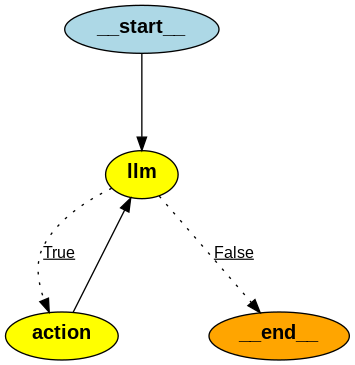

In [13]:
from IPython.display import Image

Image(agent.graph.get_graph().draw_png())

In [ ]:
Tool result: [{'content': 'Ayat Real Estate specializes in premium residential and commercial properties in Addis Ababa, offering modern living solutions.', 'metadata': {'_id': ObjectId('680549dcf56fe14e4891cbb1'), 'realEstateName': 'Ayat Real Estate', 'userId': ObjectId('68037c228077935b3446c14a'), 'email': 'jibrilarbicho185@gmail.com', 'phone': '+251 969 60 60 60', 'imageUrl': 'https://res.cloudinary.com/dnmuodgwu/image/upload/v1745177046/revostate-images/revostate-images/image-1745177045104-ayat_logo.daf534f7%20%281%29.webp', 'address': {'region': 'Addis Ababa', 'city': 'Bole', 'specificLocation': 'Getahun Besha Building, 3rd floor ; Bole Medhanialem', 'coordinates': {'lat': 9.03, 'lng': 38.74}}, 'socialMedia': {'instagram': 'https://www.instagram.com/ayatscrealestate?igsh=YTFlaDBlODQ2eTJ4', 'facebook': 'https://www.facebook.com/AyatRealEstate?mibextid=ZbWKwL', 'whatsapp': 'https://viber.com/chat?number=+251976606060'}, 'documentUrl': 'https://res.cloudinary.com/dnmuodgwu/raw/upload/v1745177050/documents/documents/doc-1745177047278-res-syllabus-2022.pdf', 'verificationStatus': 'approved', 'isVerified': True, 'createdAt': datetime.datetime(2025, 4, 20, 19, 24, 12, 149000), 'updatedAt': datetime.datetime(2025, 4, 21, 6, 22, 38, 456000), '__v': 0, 'verifiedBy': ObjectId('68037c228077935b3446c14a'), 'score': 0.8594914674758911}, 'score': 0.8594914674758911}, {'content': 'the best real estate in the country', 'metadata': {'_id': ObjectId('6807d338a67df4f92c3086c9'), 'name': 'ovid real estate', 'email': 'mikigirma1621@gmail.com', 'phone': '+25111001100', 'address': 'Addis Ababa, Ethiopia', 'website': 'https://www.ovidrealestate.com', 'documents': [], 'verificationStatus': 'approved', 'admins': [ObjectId('6807d338a67df4f92c3086cb')], 'employees': [], 'subscription': {'plan': 'basic', 'startDate': datetime.datetime(2025, 4, 22, 17, 34, 48, 322000), 'endDate': datetime.datetime(2026, 4, 22, 17, 34, 48, 322000), 'isActive': False}, 'createdAt': datetime.datetime(2025, 4, 22, 17, 34, 48, 324000), 'updatedAt': datetime.datetime(2025, 4, 22, 17, 34, 51, 584000), '__v': 1, 'score': 0.7231579422950745}, 'score': 0.7231579422950745}, {'content': 'GIFT Real Estate P.L.C. is one of the core businesses of the GIFT Business Group. and it  is one of the pioneering real estate companies in Ethiopia. It was established in 2005. It has established a solid reputation as a result of its substantial contributions throughout the years to the growth of Ethiopia’s real estate market. Its ambitious goal is to provide services to several cities in Ethiopia and other African nations.', 'metadata': {'_id': ObjectId('6806e914fb1d0b4b9c695358'), 'realEstateName': 'Gift Real Estates', 'userId': ObjectId('68035fe5047e42ae4f9b9558'), 'email': 'jibrilarbicho2@gmail.com', 'phone': '+251934044223', 'imageUrl': 'https://res.cloudinary.com/dnf1foxjf/image/upload/v1746085540/revostate-images/revostate-images/image-1746085534848-gift%20logo.webp', 'address': '{"region":"california","city":"los_angeles","specificLocation":"Blue moon bldg, Cameroon St, Addis Ababa","geoPoint":{"type":"Point","coordinates":[36.8372893,7.6753269]}}', 'socialMedia': '{"instagram":"https://web.facebook.com/giftatofficial/?_rdc=1&_rdr#","facebook":"https://web.facebook.com/giftatofficial/?_rdc=1&_rdr#","linkedin":"https://web.facebook.com/giftatofficial/?_rdc=1&_rdr#","tiktok":"https://web.facebook.com/giftatofficial/?_rdc=1&_rdr#","whatsapp":"+251934044223"}', 'documentUrl': 'https://res.cloudinary.com/dnf1foxjf/raw/upload/v1745695910/documents/documents/doc-1745695907780-company-overview-valuation-data-source.pdf.coredownload.inline.pdf', 'verificationStatus': 'approved', 'isVerified': True, 'createdAt': datetime.datetime(2025, 4, 22, 0, 55, 48, 650000), 'updatedAt': datetime.datetime(2025, 5, 1, 7, 45, 41, 227000), '__v': 0, 'verifiedAt': datetime.datetime(2025, 4, 22, 0, 59, 48, 56000), 'verifiedBy': ObjectId('68037c228077935b3446c14a'), 'score': 0.7189744710922241}, 'score': 0.7189744710922241}, {'content': 'Phison Real Estate is a real estate company that brings you modern, spacious and luxurious houses to the market. With our unique designs and eceptional service in the real estate industry, we are bringing you luxurious houses and apartments in the most residential-friendly neighborhoods of Addis Ababa.', 'metadata': {'_id': ObjectId('680d34a84db0d652265331c3'), 'realEstateName': 'Phison Real Estate', 'userId': ObjectId('68010c728baaf912f420a2af'), 'email': 'jibriil6a@gmail.com', 'phone': '+251 95 278 7878', 'imageUrl': 'https://res.cloudinary.com/dnf1foxjf/image/upload/v1745695907/revostate-images/revostate-images/image-1745695905743-channels4_profile.jpg', 'address': {'region': 'Addis Ababa', 'city': 'Bole', 'specificLocation': 'Wereda 15 ', 'geoPoint': {'type': 'Point', 'coordinates': [38.7266, 9.0064]}}, 'socialMedia': {'instagram': 'https://www.instagram.com/ayatscrealestate?igsh=YTFlaDBlODQ2eTJ4', 'facebook': 'https://www.facebook.com/phisonhomes', 'whatsapp': 'https://www.youtube.com/@phisonrealestatesc676'}, 'documentUrl': 'https://res.cloudinary.com/dnf1foxjf/raw/upload/v1745695910/documents/documents/doc-1745695907780-company-overview-valuation-data-source.pdf.coredownload.inline.pdf', 'verificationStatus': 'approved', 'isVerified': True, 'createdAt': datetime.datetime(2025, 4, 26, 19, 31, 52, 955000), 'updatedAt': datetime.datetime(2025, 4, 26, 19, 35, 39, 492000), '__v': 0, 'verifiedAt': datetime.datetime(2025, 4, 26, 19, 35, 39, 488000), 'verifiedBy': ObjectId('68069f66486be9a6ecb142ed'), 'score': 0.6881368160247803}, 'score': 0.6881368160247803}, {'content': 'DMC Real Estate specializes in luxury residential and commercial properties in Addis Ababa, offering premium real estate services.', 'metadata': {'_id': ObjectId('6806a2815b677dd6177bcb14'), 'realEstateName': 'DMC Real Estate', 'userId': ObjectId('68069f66486be9a6ecb142ed'), 'email': 'arbichoj@gmail.com', 'phone': '+251934044223', 'imageUrl': 'https://res.cloudinary.com/dnmuodgwu/image/upload/v1745265276/revostate-images/revostate-images/image-1745265274175-images.png', 'address': {'region': 'california', 'city': 'san_francisco', 'specificLocation': 'Bole,Rwanda street', 'coordinates': {'lat': 9.007923, 'lng': 38.76782}}, 'socialMedia': {'instagram': 'https://instagram.com/dmcrealestate', 'facebook': 'https://instagram.com/dmcrealestate', 'linkedin': 'https://instagram.com/dmcrealestate', 'tiktok': 'https://instagram.com/dmcrealestate', 'whatsapp': '+251934044223'}, 'documentUrl': 'https://res.cloudinary.com/dnmuodgwu/raw/upload/v1745265279/documents/documents/doc-1745265277746-res-syllabus-2022.pdf', 'verificationStatus': 'approved', 'isVerified': True, 'createdAt': datetime.datetime(2025, 4, 21, 19, 54, 41, 474000), 'updatedAt': datetime.datetime(2025, 4, 21, 19, 59, 28, 188000), '__v': 0, 'verifiedAt': datetime.datetime(2025, 4, 21, 19, 59, 28, 181000), 'verifiedBy': ObjectId('68037c228077935b3446c14a'), 'score': 0.6840735077857971}, 'score': 0.6840735077857971}, {'content': 'Metropolitan is an established property development company focused on creating homes packed with functionality, convenience and comfort for today’s modern lifestyle seeker and savvy investor.\r\n\r\nThe innovation-led, future-focused Metropolitan Real Estate established in 1995, the company is responsible for more than 450 large-scale projects worldwide. Metropolitan Real Estate has been operating in Ethiopia since 2016 G.C', 'metadata': {'_id': ObjectId('68137fc9237f278bd43205dc'), 'realEstateName': 'Metropolitan Real Estate', 'userId': ObjectId('680819ae88b733d7742fcd69'), 'email': 'info@metropolitaladdis.com', 'phone': '+251973303033', 'imageUrl': 'https://res.cloudinary.com/dnf1foxjf/image/upload/v1746108754/revostate-images/revostate-images/image-1746108748385-Metropolitan.png', 'address': '{"region":"addis_ababa","city":"bole","specificLocation":"2875 W Ray Rd #6-444 Chandler, AZ 85224","geoPoint":{"type":"Point","coordinates":[36.8372893,7.6753269]}}', 'socialMedia': '{"instagram":"https://instagram.com/ovidrealestate","facebook":"https://facebook.com/ovidrealestate","linkedin":"https://linkedin.com/company/ovidrealestate","tiktok":"https://tiktok.com/ovidrealestate","whatsapp":"+251 973 30 30 30"}', 'documentUrl': '[object File]', 'verificationStatus': 'approved', 'isVerified': True, 'createdAt': datetime.datetime(2025, 5, 1, 14, 6, 1, 714000), 'updatedAt': datetime.datetime(2025, 5, 1, 14, 12, 34, 734000), '__v': 0, 'score': 0.6593189835548401}, 'score': 0.6593189835548401}]
